![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FDev&file=Custom+Managed+Notebook.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Dev/Custom%20Managed%20Notebook.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FDev%2FCustom%2520Managed%2520Notebook.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Dev/Custom%20Managed%20Notebook.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Dev/Custom%20Managed%20Notebook.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

## Create A Custom Container for a Vertex AI Workbench Managed Notebook

- Base Image from Deep Learning Containers: https://cloud.google.com/deep-learning-containers/docs/choosing-container#deciding
    - Create a derivative container: https://cloud.google.com/deep-learning-containers/docs/derivative-container
- Add a custom container to managed notebook instance: https://cloud.google.com/vertex-ai/docs/workbench/managed/custom-container

In [61]:
import json

In [87]:
PROJECT_ID = 'statmike-demo3'
NOTEBOOK = 'custom_notebook_example'
REGION = 'us-central1'
BASE_IMAGE = 'gcr.io/deeplearning-platform-release/base-cpu'

In [88]:
#BUCKET = PROJECT_ID
#URI = f"gs://{BUCKET}/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

In [89]:
!rm -rf {DIR}
!mkdir -p {DIR}

In [90]:
!mkdir -p {DIR}/scripts

test here first

---
## Setup Repository

In [91]:
services = !gcloud services list --format="json" --available --filter=name:artifactregistry.googleapis.com
services = json.loads("".join(services))

if (services[0]['config']['name'] == 'artifactregistry.googleapis.com') & (services[0]['state'] == 'ENABLED'):
    print(f"Artifact Registry is Enabled for This Project: {PROJECT_ID}")
else:
    print(f"Enabeling Artifact Registry for this Project: {PROJECT_ID}")
    !gcloud services enable artifactregistry.googleapis.com

Artifact Registry is Enabled for This Project: statmike-demo3


In [92]:
repositories = !gcloud artifacts repositories list --format="json" --filter=REPOSITORY:{PROJECT_ID}
repositories = json.loads("".join(repositories[2:]))

if len(repositories) > 0:
    print(f'There is already a repository named {PROJECT_ID}')
else:
    print(f'Creating a repository named {PROJECT_ID}')
    !gcloud  artifacts repositories create {PROJECT_ID} --repository-format=docker --location={REGION} --description="Vertex AI Training Custom Containers"

There is already a repository named statmike-demo3


In [93]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


In [94]:
IMAGE_URI=f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{PROJECT_ID}/{NOTEBOOK}:latest"
IMAGE_URI

'us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/custom_notebook_example:latest'

---
## OLD - Use .sh script with Dockerfile

In [7]:
%%writefile {DIR}/scripts/install_google_drive.sh
sudo apt install -y opam

sudo apt install -y libcurl4-gnutls-dev libfuse-dev libgmp-dev libsqlite3-dev m4 zlib1g-dev # dependencies for google-drive-ocamlfuse
sudo apt-get install -y fuse
sudo apt-get install -y xdg-utils --fix-missing
sudo apt-get install -y xdg-utils --fix-missing
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
sudo apt install -y ./google-chrome-stable_current_amd64.deb
sudo apt autoremove -y
sudo apt-get install -y chromium

sudo apt-get install opam ocaml make fuse camlp4-extra build-essential pkg-config

opam init
eval `opam config env`
opam update
opam install depext

opam init --yes
eval `opam config env` # set needed environment variables
opam update --yes
opam install depext --yes
opam depext google-drive-ocamlfuse --yes
opam install google-drive-ocamlfuse --yes
sudo apt-get install lynx --yes

sudo mkdir -p ~/gdrive
sudo chmod 777 ~/gdrive

Writing temp/custom_notebook/scripts/install_google_drive.sh


In [40]:
dockerfile = f"""
FROM {BASE_IMAGE}
RUN mkdir -p /scripts
COPY install_google_drive.sh /scripts
WORKDIR /scripts
RUN chmod +x install_google_drive.sh
RUN ./install_google_drive.sh
""".strip()
with open(f'{DIR}/scripts/Dockerfile', 'w') as f:
    f.write(dockerfile)

In [ ]:
!docker build {DIR}/scripts/. -t $IMAGE_URI --quiet

In [ ]:
!docker push $IMAGE_URI

---
## Add Pip Installs with Dockerfile

In [95]:
dockerfile = f"""
FROM {BASE_IMAGE}
RUN pip install python-Levenshtein fuzzywuzzy fuzzysearch jsonlines
""".strip()
with open(f'{DIR}/scripts/Dockerfile', 'w') as f:
    f.write(dockerfile)

In [96]:
!docker build {DIR}/scripts/. -t $IMAGE_URI --quiet

sha256:8c95aaee94680eff3c7323bf6e2fe795eeeac964c4d45631d90934f96148fc43


In [97]:
!docker push $IMAGE_URI

The push refers to repository [us-central1-docker.pkg.dev/statmike-demo3/statmike-demo3/custom_notebook_example]

076e0ddf: Preparing 
dd2b9e38: Preparing 
e29d8d24: Preparing 
95a574c8: Preparing 
10151b48: Preparing 
c089358e: Preparing 
9b36546a: Preparing 
82ce8d0b: Preparing 
467ac3a5: Preparing 
91c31559: Preparing 
ae11254c: Preparing 
2bcbe281: Preparing 
4c112e39: Preparing 
048fd290: Preparing 
bf18a086: Preparing 
7a45d8d8: Preparing 
6651fb01: Preparing 
d5cafaa0: Preparing 
76e0ddf: Pushed   2.756MBists MB14Alatest: digest: sha256:b15ae3ad8fca94de7c0b1ef1cb4617da89ac12e5a283cd419c9b6a536b042848 size: 4291


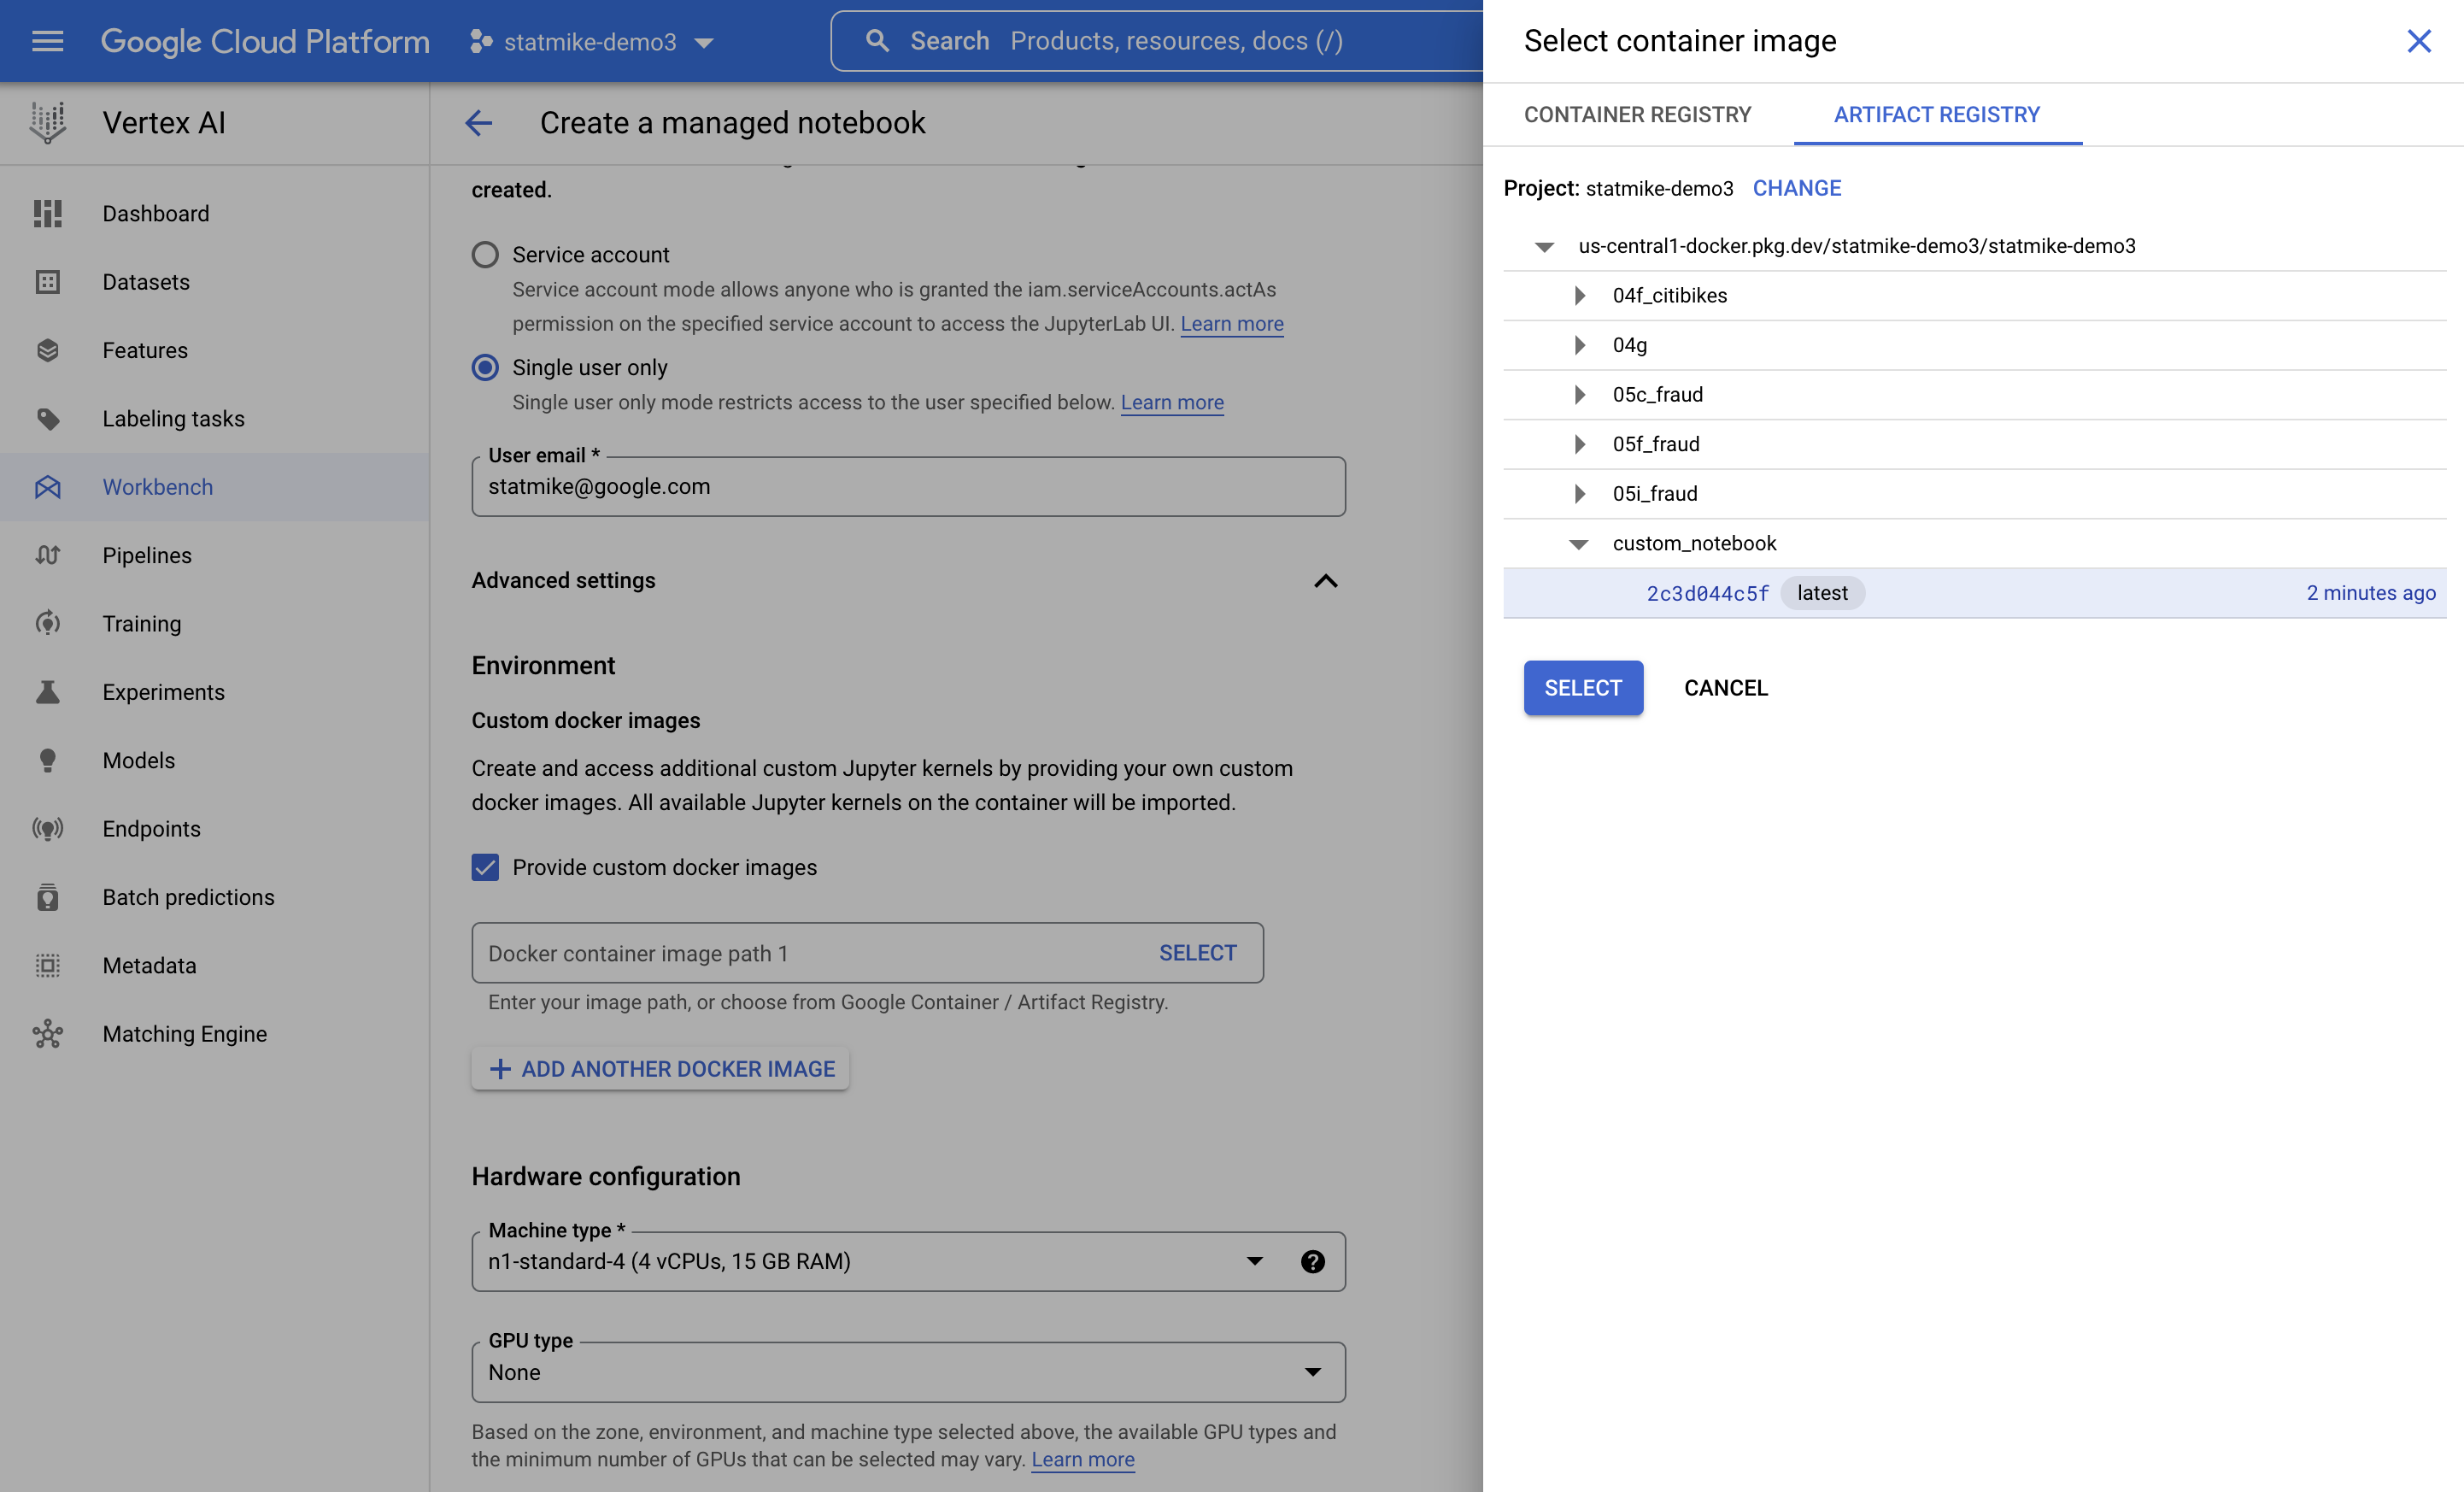

The activity log loading circle went for a very long time - maybe 45 minutes